In [2]:
import numpy as np
import gc
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import seaborn as sns
from pathlib import Path
from scipy.spatial import distance_matrix

In [3]:
def read_bl2(path):
    return np.core.records.fromfile(str(path),formats='f8,(2048)i2,f8,(2048)i2',names='tstamp,pwave,ptime,wave')

In [3]:
saturatedData = np.array(np.arange(2048))
# List all files in directory using pathlib
basepath = Path("/Users/elicarter/Local/FominResearch/RealData/Runs/s_1000")
files_in_basepath = (entry for entry in basepath.iterdir() if entry.is_file())
for item in files_in_basepath:
    if str(item).endswith(".dat"):
        print("Adding " + str(item))
        saturatedData = np.vstack((saturatedData, read_bl2(item)["wave"]))
saturatedData = np.delete(saturatedData, [0], 0) #delete the placeholder shape row

Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000010_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000050_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000090_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000070_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000020_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000001_1.dat


In [4]:
#delete all data that goes over 30,000 as it's pre amp saturated
data = np.copy(saturatedData)
over30k = False
#iterate backwards to avoid index proboems with removing
for i in range(len(saturatedData)-1,-1,-1):
    for j in range(len(saturatedData[0])-1,-1,-1):
        if (saturatedData[i,j] > 30000):
            data = np.delete(data, i, axis=0)
            break

In [5]:
np.random.shuffle(data)
print(np.shape(saturatedData))
print(np.shape(data))
del saturatedData
gc.collect()

(8590, 2048)
(8554, 2048)


47

In [6]:
#add 10k to avoid dividing by almost 0
for i in range(len(data)):
    data[i] = data[i]+10000

In [7]:
colors = {}
colors[-1] = 'black'
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'pink'
colors[7] = 'purple'
colors[8] = 'silver'
colors[9] = 'brown'
colors[10] = 'olive'
colors[11] = 'aquamarine'
colors[12] = 'cornflowerblue'
colors[13] = 'teal'
colors[14] = 'salmon'
colors[15] = 'lime'
colors[16] = 'gold'

# Dimensionality Reduction using principal component analysis

In [8]:
u, s, vh = np.linalg.svd(data, full_matrices=False)

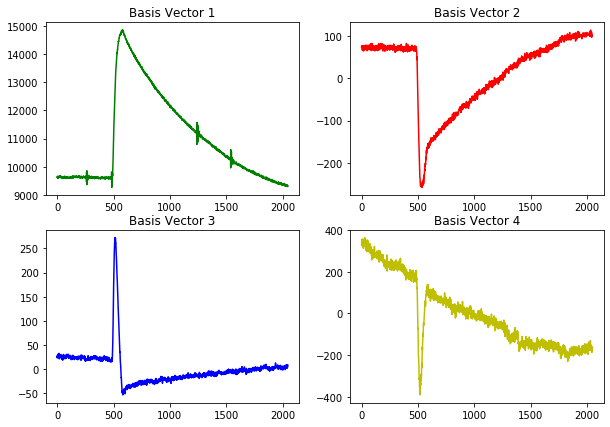

In [9]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].plot(u[0,0]*s[0]*vh[0], color = 'g')
ax[0,0].title.set_text("Basis Vector 1")
ax[0,1].plot(u[1,1]*s[1]*vh[1], color = 'r')
ax[0,1].title.set_text("Basis Vector 2")
ax[1,0].plot(u[2,2]*s[2]*vh[2], color = 'b')
ax[1,0].title.set_text("Basis Vector 3")
ax[1,1].plot(u[3,3]*s[3]*vh[3], color = 'y')
ax[1,1].title.set_text("Basis Vector 4")

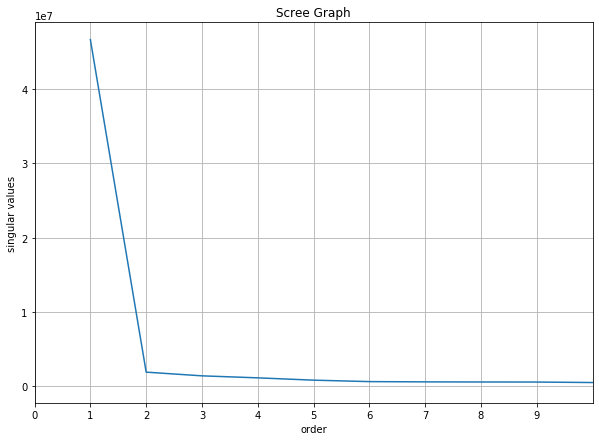

In [10]:
scree_order = np.arange(1,len(s)+1)
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, s)
ax.title.set_text("Scree Graph")
ax.set_ylabel("singular values")
ax.set_xlabel("order")
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

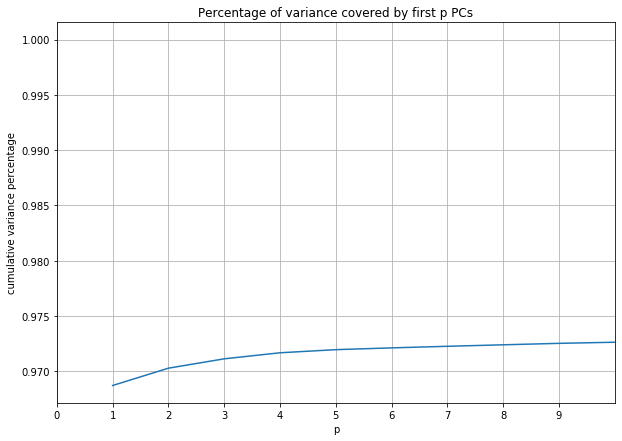

In [11]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]
    
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance
    
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, pvc)
ax.title.set_text('Percentage of variance covered by first p PCs')
ax.set_xlabel('p')
ax.set_ylabel('cumulative variance percentage')
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

In [12]:
v = np.transpose(vh)
vD = v[:,:5]
rDataD = data@vD

In [13]:
del u, s, vh, vD
gc.collect()

11355

# Start HDBScan

In [14]:
doubleDistances = distance_matrix(rDataD, rDataD)
#double counts distances. Get upper triangle matrix then manipulate it 
temp = np.triu(doubleDistances)
distances = np.asarray(temp).reshape(-1)
distances = np.sort(distances)
distances = np.flip(distances)
#remove 0s where repeats used to be
nonzeros = int((len(doubleDistances)*len(doubleDistances) - 1)/2)
distances = distances[0:nonzeros]
order = np.arange

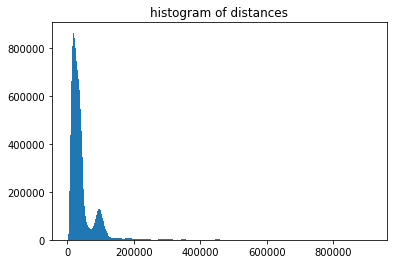

In [15]:
plt.title("histogram of distances")
fig11 = plt.hist(distances, 1000)

In [16]:
hdb = hdbscan.HDBSCAN(min_cluster_size=17, gen_min_span_tree=True).fit(rDataD)
labels = hdb.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

counts = np.zeros(n_clusters)
for i in range(n_clusters):
    for label in labels:
        if label == i:
            counts[i] += 1
            
percentage_counts = counts/len(data)
for i in range(len(percentage_counts)):
    percentage_counts[i] = round(percentage_counts[i], 3)

In [17]:
print ("Number of clusters: " + str(n_clusters))
print ("Number of noise points: " + str(n_noise))
print ("% of data included in clustering: " + str (1 - n_noise/len(labels)))

Number of clusters: 3
Number of noise points: 110
% of data included in clustering: 0.9871405190554127


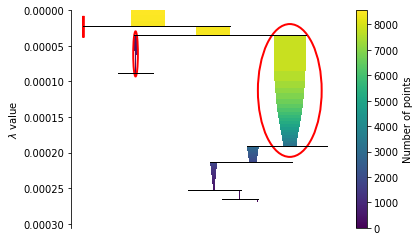

In [18]:
hdb.condensed_tree_.plot(select_clusters=True)

In [19]:
avgSin = np.arange(2048)
avgDou = np.arange(2048)
avgTri = np.arange(2048)
numSin = 0
numDou = 0
numTri = 0
avgSin = avgSin.astype(float)
avgDou = avgSin.astype(float)
avgTri = avgSin.astype(float)

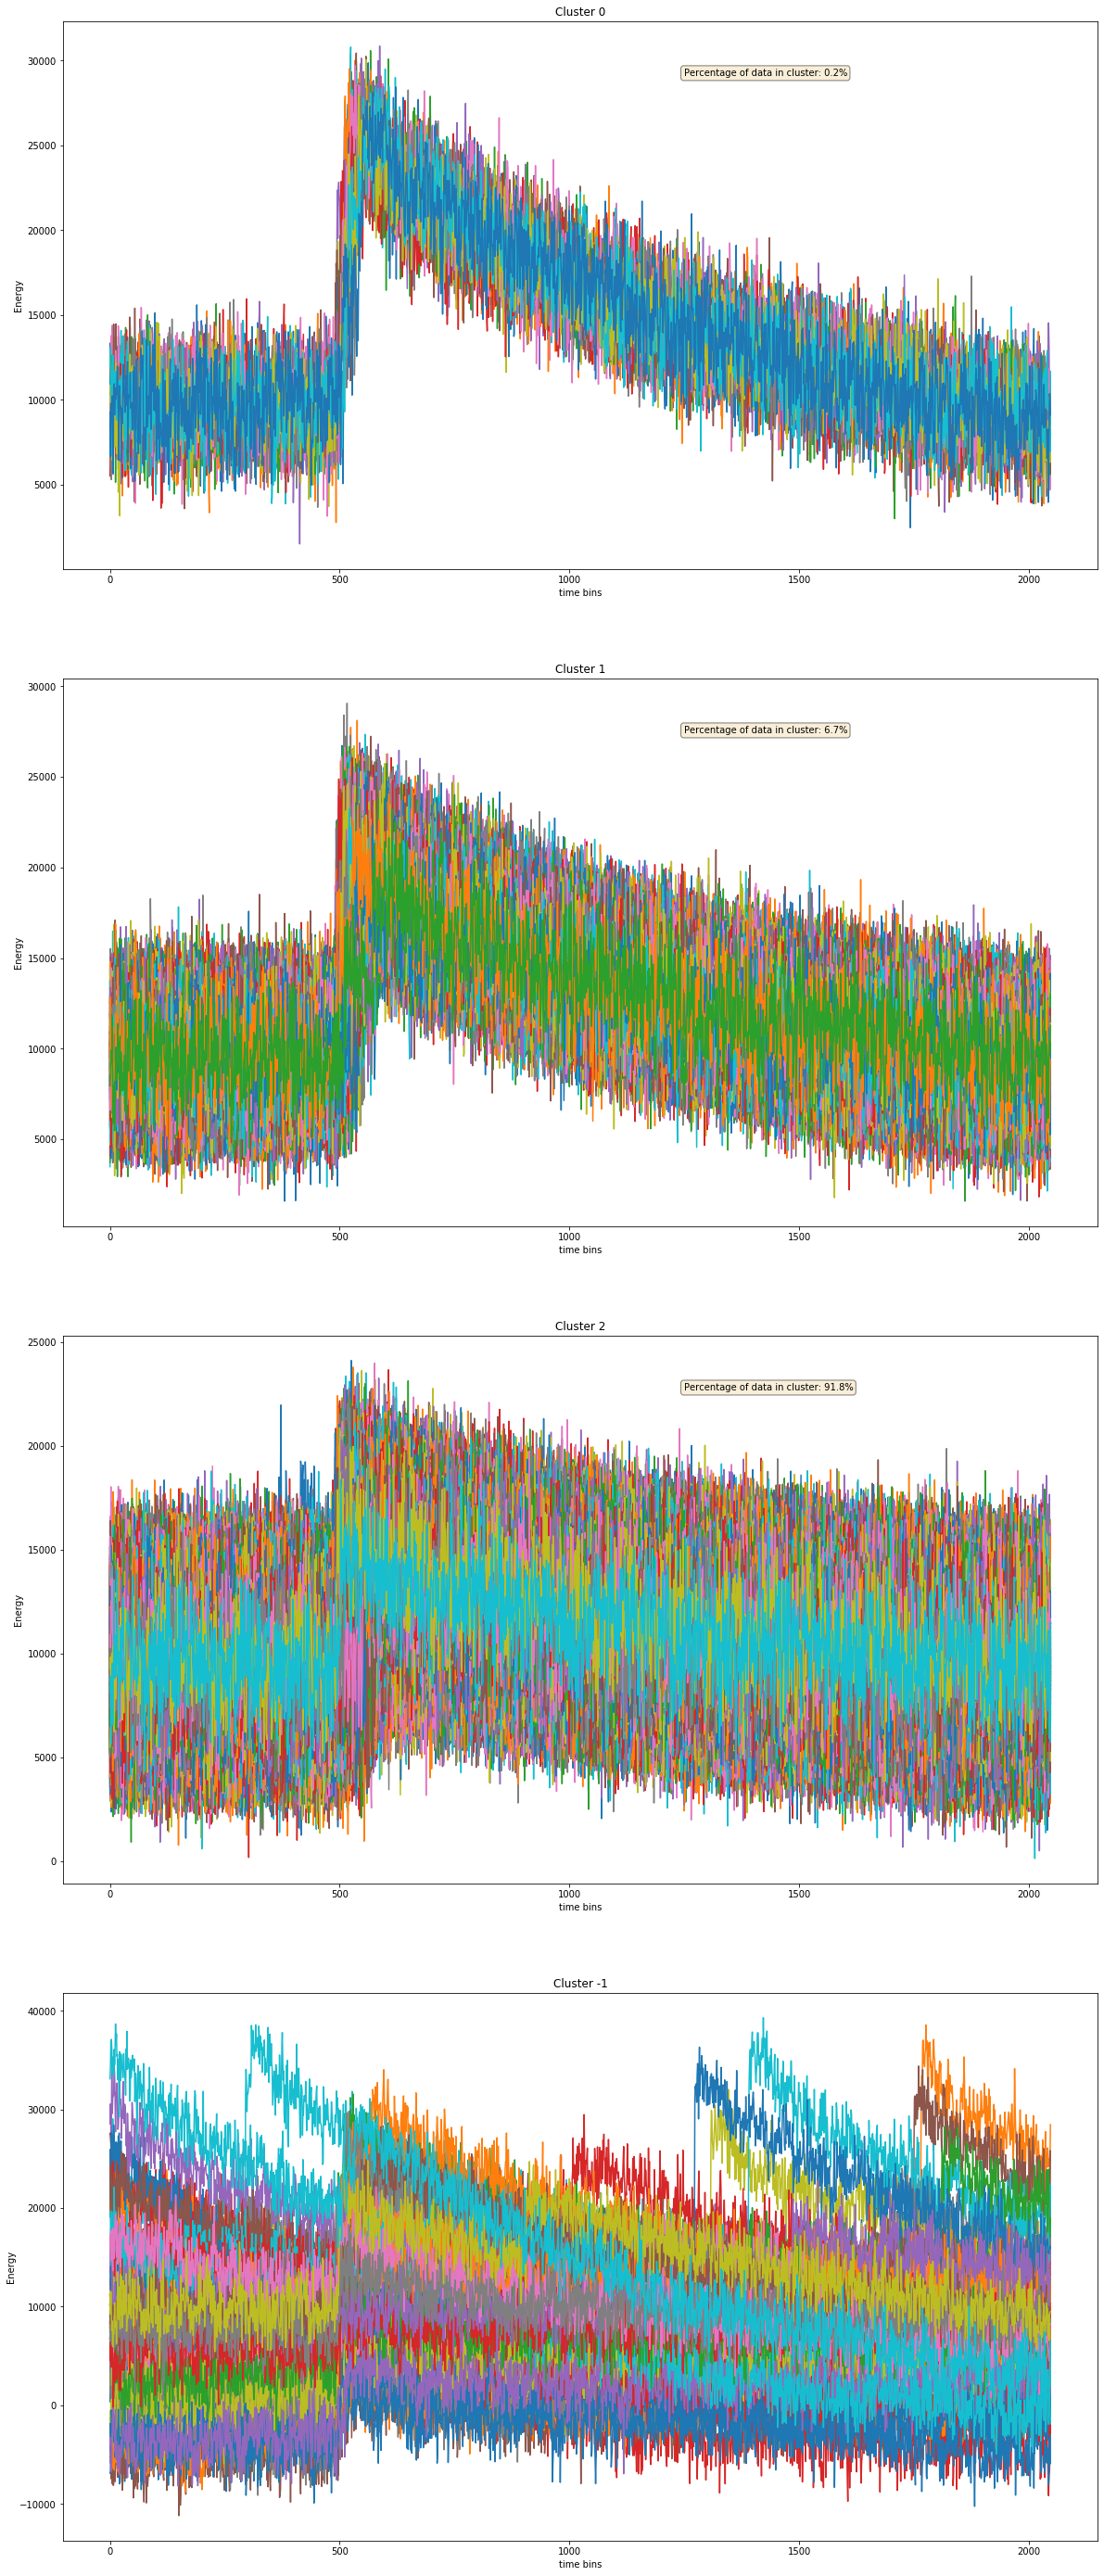

In [20]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(n_clusters+1, figsize = (20,50))
t = np.arange(2048)
for n in range(len(labels)):
    for i in range(-1, n_clusters):
        if i == labels[n]:
            #collecting averages
            if i == 1:
                avgSin += data[n]
                numSin += 1
            if i == 2:
                avgDou += data[n]
                numDou += 1
            if i == 0:
                avgTri += data[n]
                numTri += 1
            ax[i].plot(t, data[n])
            ax[i].title.set_text("Cluster " + str(i))
            ax[i].set_xlabel("time bins")
            ax[i].set_ylabel("Energy")
for i in range(n_clusters):
        text_x = ax[i].get_xlim()[1] - 0.4*(ax[i].get_xlim()[1] - ax[i].get_xlim()[0])
        text_y = ax[i].get_ylim()[1] - 0.1*(ax[i].get_ylim()[1] - ax[i].get_ylim()[0])
        ax[i].text(text_x, text_y, "Percentage of data in cluster: " + str(round(100*percentage_counts[i], 3)) + "%", bbox = props)
plt.show()

# Averages and analysis of clusters

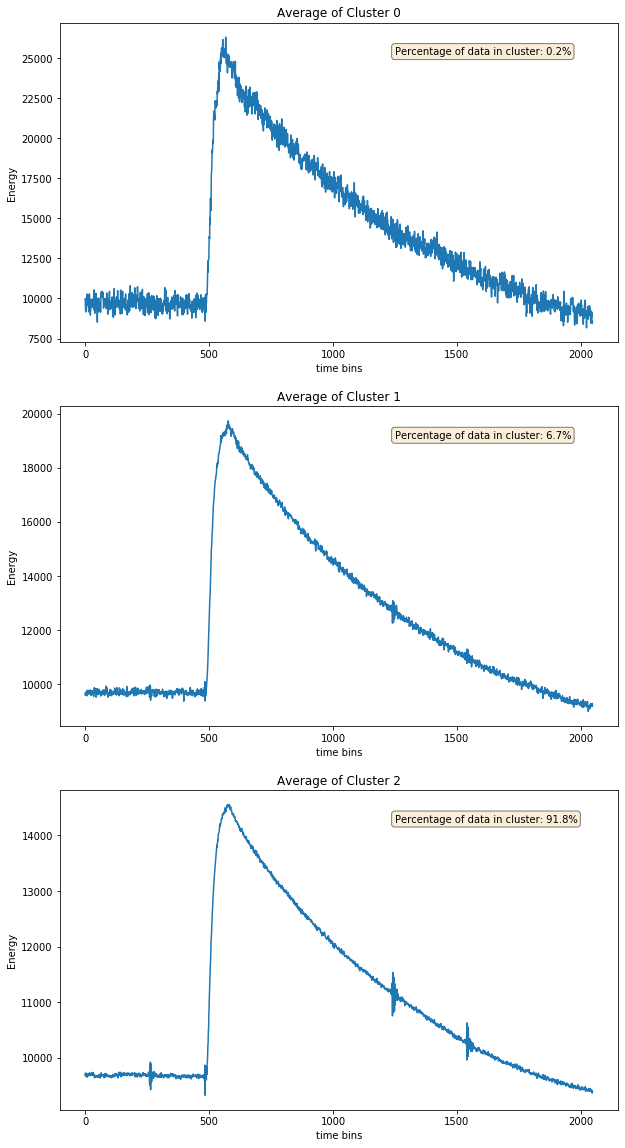

In [21]:
for i in range(2048):
    avgSin[i] = avgSin[i]/numSin
    avgDou[i] = avgDou[i]/numDou
    avgTri[i] = avgTri[i]/numTri
avgs = np.vstack((avgTri, avgSin, avgDou))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(len(avgs), figsize = (10,20))    
for i in range(len(avgs)):
    ax[i].plot(t, avgs[i])
    ax[i].title.set_text("Average of Cluster " + str(i))
    ax[i].set_xlabel("time bins")
    ax[i].set_ylabel("Energy")
for i in range(n_clusters):
        text_x = ax[i].get_xlim()[1] - 0.4*(ax[i].get_xlim()[1] - ax[i].get_xlim()[0])
        text_y = ax[i].get_ylim()[1] - 0.1*(ax[i].get_ylim()[1] - ax[i].get_ylim()[0])
        ax[i].text(text_x, text_y, "Percentage of data in cluster: " + str(round(100*percentage_counts[i], 3)) + "%", bbox = props)
plt.show()

In [22]:
#add 10k to avoid dividing by almost 0
#avgSin = avgSin + 10000
#avgDou = avgDou + 10000
#avgTri = avgTri + 10000
#for i in range(len(data)):
    #data[i] = data[i]+10000

In [23]:
#sum over ratio differenece when comparing each waveform to average
agg_ratios = np.arange(len(data))
for n in range(len(data)):
    if labels[n] == 1:
        for time in range(2048):
            agg_ratios[n] += data[n][time]/avgs[1][time]
    if labels[n] == 2:
        for time in range(2048):
            agg_ratios[n] += data[n][time]/avgs[2][time]
    if labels[n] == 0:
        for time in range(2048):
            agg_ratios[n] += data[n][time]/avgs[0][time]
#normalize
agg_ratios = agg_ratios/2048

In [24]:
print(agg_ratios)

[0.49853516 0.54736328 0.44189453 ... 4.62451172 4.72949219 4.63671875]


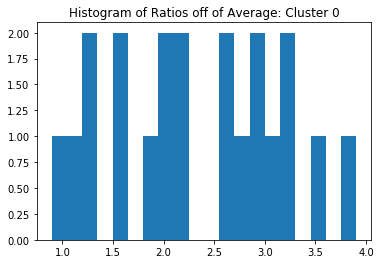

In [25]:
plt.title("Histogram of Ratios off of Average: Cluster 0")
fig11 = plt.hist([agg_ratios[n] for n in range(len(data)) if labels[n] == 0], bins=20)

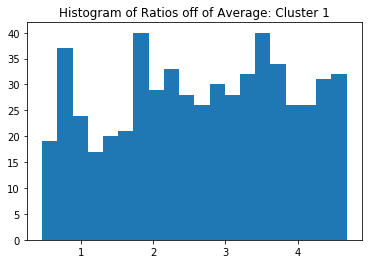

In [26]:
plt.title("Histogram of Ratios off of Average: Cluster 1")
fig11 = plt.hist([agg_ratios[n] for n in range(len(data)) if labels[n] == 1], bins=20)

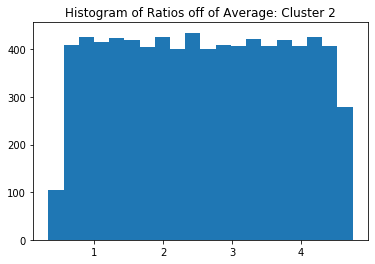

In [27]:
plt.title("Histogram of Ratios off of Average: Cluster 2")
fig11 = plt.hist([agg_ratios[n] for n in range(len(data)) if labels[n] == 2], bins=20)

(404, 2048)


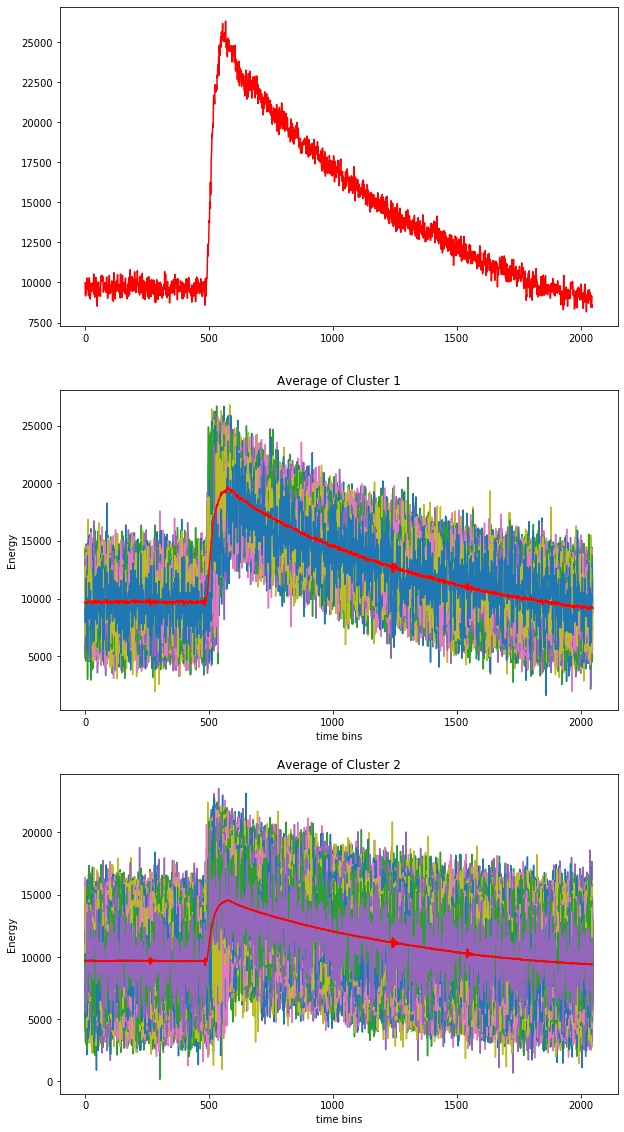

In [28]:
highR_data = [data[n] for n in range(len(data)) if abs(agg_ratios[n]-2.5) > 2]
print(np.shape(highR_data))
fig, ax = plt.subplots(len(avgs), figsize = (10,20))
for n in range(len(data)):
    for i in range(len(avgs)):
        if (labels[n] == i and (agg_ratios[n]-2) > 2):
            ax[i].plot(t, data[n])
            ax[i].plot(t, avgs[i])
            ax[i].title.set_text("Average of Cluster " + str(i))
            ax[i].set_xlabel("time bins")
            ax[i].set_ylabel("Energy")
for i in range(len(avgs)):
    ax[i].plot(t, avgs[i],"red")